# Middle Term Test 2 - COVID-19 Fake News Detection

## Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Cargar Dataset

In [13]:
# Cargar los datasets
train_df = pd.read_excel('data/Constraint_English_Train.xlsx')
val_df = pd.read_excel('data/Constraint_English_Val.xlsx')
test_df = pd.read_excel('data/Constraint_English_Test.xlsx')

# Mostrar información básica
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("\nPrimeras filas del dataset de entrenamiento:")
train_df.head()

Train shape: (6420, 3)
Validation shape: (2140, 3)
Test shape: (2140, 2)

Primeras filas del dataset de entrenamiento:


,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


Primero, estudiamos los datos del dataset

In [14]:
print(train_df.isnull().sum())

id       0
tweet    0
label    0
dtype: int64


## Análisis de la distribución de clases
Vamos a visualizar cuántas noticias reales y falsas hay en el dataset de entrenamiento.

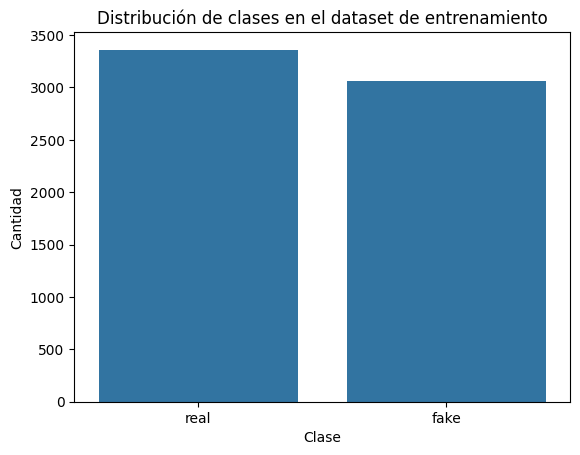

In [15]:
# Visualizar la distribución de clases en el dataset de entrenamiento
sns.countplot(x='label', data=train_df)
plt.title('Distribución de clases en el dataset de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

##  Tokenización de las palabras
Ahora vamos a empezar a tokenizar las palabras del dataset

In [16]:
# Definir la lista de stopwords en inglés
stop_words = set(stopwords.words("english"))

# Tokenizar y filtrar cada tweet
train_df['tokens'] = train_df['tweet'].apply(lambda x: [w for w in word_tokenize(str(x)) if w.lower() not in stop_words and w.isalpha()])

# Mostrar los primeros ejemplos tokenizados
train_df[['tweet', 'tokens']]

,tweet,tokens
0,The CDC currently reports 99031 deaths. In gen...,"[CDC, currently, reports, deaths, general, dis..."
1,States reported 1121 deaths a small rise from ...,"[States, reported, deaths, small, rise, last, ..."
2,Politically Correct Woman (Almost) Uses Pandem...,"[Politically, Correct, Woman, Almost, Uses, Pa..."
3,#IndiaFightsCorona: We have 1524 #COVID testin...,"[IndiaFightsCorona, COVID, testing, laboratori..."
4,Populous states can generate large case counts...,"[Populous, states, generate, large, case, coun..."
...,...,...
6415,A tiger tested positive for COVID-19 please st...,"[tiger, tested, positive, please, stay, away, ..."
6416,???Autopsies prove that COVID-19 is??� a blood...,"[Autopsies, prove, blood, clot, pneumonia, oug..."
6417,_A post claims a COVID-19 vaccine has already ...,"[post, claims, vaccine, already, developed, ca..."
6418,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,"[Aamir, Khan, Donate, Cr, PM, Relief, Cares, F..."


## Relación entre tokens y la veracidad
Vamos a analizar si existen tokens (palabras) que aparecen con mayor frecuencia en noticias verdaderas o falsas.

In [17]:
from collections import Counter
import itertools
 
# Separar los tweets verdaderos y falsos
true_tokens = list(itertools.chain.from_iterable(train_df[train_df['label']=='real']['tokens']))
fake_tokens = list(itertools.chain.from_iterable(train_df[train_df['label']=='fake']['tokens']))
 
# Contar las palabras más frecuentes en cada grupo
true_freq = Counter(true_tokens).most_common(20)
fake_freq = Counter(fake_tokens).most_common(20)
 
print('Palabras más frecuentes en noticias VERDADERAS:')
print(true_freq)
print('\nPalabras más frecuentes en noticias FALSAS:')
print(fake_freq)

Palabras más frecuentes en noticias VERDADERAS:
[('https', 3118), ('cases', 1485), ('tests', 605), ('new', 603), ('number', 489), ('deaths', 445), ('reported', 443), ('people', 439), ('confirmed', 431), ('amp', 424), ('total', 411), ('testing', 361), ('IndiaFightsCorona', 317), ('India', 284), ('today', 280), ('states', 279), ('report', 277), ('New', 255), ('COVID', 246), ('coronavirus', 245)]

Palabras más frecuentes en noticias FALSAS:
[('https', 1254), ('coronavirus', 1043), ('people', 260), ('Trump', 248), ('Coronavirus', 231), ('pandemic', 209), ('India', 203), ('virus', 183), ('vaccine', 170), ('video', 155), ('President', 142), ('cases', 139), ('new', 135), ('said', 129), ('shows', 129), ('claims', 122), ('lockdown', 119), ('patients', 113), ('died', 110), ('hospital', 105)]


## Tokens con mayor proporción de verdad
Ahora vamos a calcular, para cada token, el porcentaje de veces que aparece en noticias verdaderas respecto al total de apariciones.

In [18]:
# Calcular el porcentaje de verdad para cada token
all_tokens = list(itertools.chain.from_iterable(train_df['tokens']))
all_freq = Counter(all_tokens)
true_freq = Counter(true_tokens)
 
# Crear un DataFrame con el porcentaje de verdad
token_stats = pd.DataFrame({
    'token': list(all_freq.keys()),
    'total': [all_freq[t] for t in all_freq],
    'verdaderas': [true_freq[t] for t in all_freq],
})
token_stats['porcentaje_verdad'] = token_stats['verdaderas'] / token_stats['total']
 
# Mostrar los tokens con mayor porcentaje de verdad (mínimo 10 apariciones para evitar sesgos)
tokens_filtrados = token_stats[token_stats['total'] >= 10]
top_tokens = tokens_filtrados.sort_values('porcentaje_verdad', ascending=False).head(20)
print(top_tokens[['token', 'total', 'verdaderas', 'porcentaje_verdad']])

              token  total  verdaderas  porcentaje_verdad
14          roughly     10          10                1.0
1577         Follow     22          22                1.0
1688     considered     26          26                1.0
40     laboratories     69          69                1.0
1690            MIQ     29          29                1.0
1514            Kia     14          14                1.0
1532     mygovindia     21          21                1.0
1531  airnewsalerts     30          30                1.0
1714      processed     41          41                1.0
1746        pending     18          18                1.0
1464     strategies     10          10                1.0
1515            ora     13          13                1.0
5839          refer     10          10                1.0
1489        Waikato     15          15                1.0
1479           Kano     12          12                1.0
1478    Fmohnigeria     10          10                1.0
1363          

## Entrenamiento usando tokens con 100% de probabilidad de verdad
Entrenaremos el modelo usando solo las palabras que aparecen exclusivamente en noticias verdaderas.

In [19]:
# Seleccionar tokens con 100% de probabilidad de verdad y al menos 10 apariciones
tokens_100 = tokens_filtrados[tokens_filtrados['porcentaje_verdad'] == 1]['token'].tolist()
 
# Vectorizar solo usando esos tokens
vectorizer_100 = CountVectorizer(vocabulary=tokens_100)
X_train_100 = vectorizer_100.transform(train_df['tweet'])
y_train = train_df['label']
 
# Entrenar el modelo
model_100 = LogisticRegression()
model_100.fit(X_train_100, y_train)
 
print(f"Número de tokens usados: {len(tokens_100)}")

Número de tokens usados: 128


Accuracy: 0.5976635514018691

Classification report:
              precision    recall  f1-score   support

        fake       0.54      0.98      0.70      1020
        real       0.95      0.25      0.39      1120

    accuracy                           0.60      2140
   macro avg       0.74      0.61      0.54      2140
weighted avg       0.75      0.60      0.54      2140



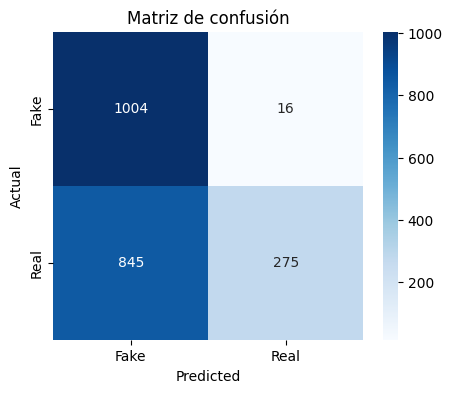

In [21]:
# Evaluar el modelo en el conjunto de validación
X_val_100 = vectorizer_100.transform(val_df['tweet'])
y_val = val_df['label']
 
y_pred = model_100.predict(X_val_100)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification report:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión')
plt.show()